In [9]:
#Importing the libraries

from bs4 import BeautifulSoup
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Reading the table containing Headlines from html file

In [10]:
html_tables = {}

for file_name in os.listdir('datasets'):
    file_path = f'datasets/{file_name}'
    file_object = open(file_path,'r')
    html = BeautifulSoup(file_object)
    # finding the headlines table which has id news-table
    html_table = html.find(id = 'news-table')
    # Adding the table name to the dictionary
    html_tables[file_name] = html_table

In [3]:
#html_tables

## Exploring the data from the headlines table

In [11]:
html_tables.keys()

dict_keys(['fb_05ene.html', 'fb_22sep.html', 'tsla_05ene.html', 'tsla_22sep.html', 'tsla_26nov.html'])

In [13]:
# Reading facebook headlines from sep 22nd
fb = html_tables['fb_22sep.html']

# Reading the <tr> in the above table
fb_tr = fb.findAll('tr')

for i, table_row in enumerate(fb_tr):
    # Reading the data from <td> tag
    data_text = table_row.td.get_text()
    
    # Reading data from <a> tag
    link_text = table_row.a.get_text()
    
    #Printing the first 5 headines from the table
    print(f'{i}:')
    print(data_text)
    print(link_text)
    
    # Breaking the loop after 5 iterations
    if i == 5:
        break

0:
Sep-22-18 11:08AM  
How former Facebook and Google engineer Bret Taylor earned Marc Benioff's trust at Salesforce
1:
12:02AM  
White House Drafts Order To Look Into Google, Facebook Practices
2:
Sep-21-18 06:21PM  
Facebook Withdraws Direct Promotion of Political Campaigns
3:
06:18PM  
Facebook's Plan to Pull Back Campaign Support to Trump in 2020
4:
06:17PM  
Facebook's Plan to Pull Back Campaign Support to Trump in 2020
5:
06:10PM  
Does F.A.N.G. still stand? 8 trades


## Extracting Headlines along with company name, date and time

In [14]:
parsed_news = []

# Going over HTML table
for file_name, news_table in html_tables.items():
    # Iterating over teach <tr> tag and extracting headlines(from <a>) and
    # date and time(from <th>)
    for table_row in news_table.findAll('tr'):
        headlines = table_row.a.get_text()
        data_text = table_row.td.get_text().split()
        
        if len(data_text) == 1:
            time = data_text[0]
        else:
            date = data_text[0]
            time = data_text[1]
            
        company = file_name.split('_')[0]
        
        parsed_news.append([company, date, time, headlines])

In [15]:
parsed_news[:5]

[['fb',
  'Jan-04-19',
  '06:22PM',
  'Facebook, Apple, Netflix, Amazon and Alphabet Power Friday Gains'],
 ['fb',
  'Jan-04-19',
  '05:15PM',
  'Earnings Reports for the Week of Jan. 7-11 (BBBY, KBH)'],
 ['fb',
  'Jan-04-19',
  '04:55PM',
  'COLUMN-Commentary: 2019 will be the year of more state control'],
 ['fb', 'Jan-04-19', '04:53PM', '3 Tech Trends to Watch in 2019'],
 ['fb', 'Jan-04-19', '04:30PM', "Will Denver's tech growth continue in 2019?"]]

### Updating NLTK to identify financial sentiment

In [18]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer


In [21]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kowshik\AppData\Roaming\nltk_data...


True

In [22]:
# New words and values for making lexicon read financial sentiment
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()
# Updating the vader lexicon
vader.lexicon.update(new_words)

## Reading the data into dataframe

In [23]:
columns = ['company', 'date', 'time', 'headline']

# Convert the list of lists into a DataFrame with above columns
scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores
scores = [vader.polarity_scores(headline) for headline in scored_news.headline.values]

# creating the polarity scores dataframe
scores_df = pd.DataFrame(scores)

# Join the DataFrames
scored_news = pd.concat([scored_news, scores_df], axis=1)

# Convert the date column from string to datetime
scored_news['date'] = pd.to_datetime(scored_news.date).dt.date

## Plotting the Sentiments

In [24]:
mean_value = scored_news.groupby(['date','company']).mean()
mean_value.head()

neg       neu       pos  compound
date       company                                        
2018-09-18 fb       0.104864  0.843682  0.051455 -0.052564
           tsla     0.112875  0.807688  0.079437 -0.085650
2018-09-19 fb       0.072920  0.805560  0.121640  0.057568
           tsla     0.066366  0.879610  0.054000 -0.025949
2018-09-20 fb       0.059567  0.870233  0.070200  0.018447

In [25]:
mean_value = mean_value.unstack(level=1)
mean_value.head()

neg                 neu                 pos            \
company           fb      tsla        fb      tsla        fb      tsla   
date                                                                     
2018-09-18  0.104864  0.112875  0.843682  0.807688  0.051455  0.079437   
2018-09-19  0.072920  0.066366  0.805560  0.879610  0.121640  0.054000   
2018-09-20  0.059567  0.067304  0.870233  0.762609  0.070200  0.170087   
2018-09-21  0.052762  0.102800  0.886381  0.818600  0.060857  0.078600   
2018-09-22  0.000000       NaN  0.899000       NaN  0.101000       NaN   

            compound            
company           fb      tsla  
date                            
2018-09-18 -0.052564 -0.085650  
2018-09-19  0.057568 -0.025949  
2018-09-20  0.018447  0.148757  
2018-09-21  0.014310 -0.049575  
2018-09-22  0.255300       NaN

In [26]:
mean_value = mean_value.xs('compound', axis = 1)
mean_value.head()

company,fb,tsla
date,,
2018-09-18,-0.052564,-0.085650
2018-09-19,0.057568,-0.025949
2018-09-20,0.018447,0.148757
2018-09-21,0.014310,-0.049575
2018-09-22,0.255300,NaN


<AxesSubplot:xlabel='date'>

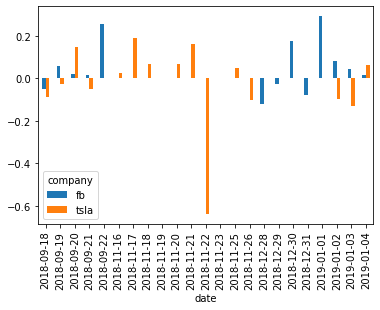

In [27]:
mean_value.plot.bar()

## Check Duplicate Headlines

In [28]:
num_news_before = scored_news['headline'].count()
num_news_before

500

In [29]:
scored_news_clean = scored_news.drop_duplicates(subset=['company','headline'])

In [30]:
scored_news_after = scored_news_clean['headline'].count()

In [31]:
print(f"Before we had {num_news_before} after removing duplicates we have {scored_news_after}")

Before we had 500 after removing duplicates we have 476


## Visualizing sentiment of a stock for a single day

In [32]:
single_day = scored_news_clean.set_index(['company','date'])
single_day.head()

time  \
company date                  
fb      2019-01-04  06:22PM   
        2019-01-04  05:15PM   
        2019-01-04  04:55PM   
        2019-01-04  04:53PM   
        2019-01-04  04:30PM   

                                                             headline  neg  \
company date                                                                 
fb      2019-01-04  Facebook, Apple, Netflix, Amazon and Alphabet ...  0.0   
        2019-01-04  Earnings Reports for the Week of Jan. 7-11 (BB...  0.0   
        2019-01-04  COLUMN-Commentary: 2019 will be the year of mo...  0.0   
        2019-01-04                     3 Tech Trends to Watch in 2019  0.0   
        2019-01-04        Will Denver's tech growth continue in 2019?  0.0   

                      neu    pos  compound  
company date                                
fb      2019-01-04  0.631  0.369    0.4767  
        2019-01-04  1.000  0.000    0.0000  
        2019-01-04  1.000  0.000    0.0000  
        2019-01-04  1.000  0.000    0.0000  
        2019-01-04  0.698  0.302    0.3818

In [33]:
single_day = single_day.loc['tsla']
single_day.head()

,time,headline,neg,neu,pos,compound
date,,,,,,
2019-01-04,08:36PM,Why Tesla Stock Popped 6%,0.000,1.000,0.000,0.0000
2019-01-04,07:42PM,Tesla urges tariff exemption for Chinese-made ...,0.000,1.000,0.000,0.0000
2019-01-04,06:19PM,Elon Musk Isnt Keen on Investors Dragging Girl...,0.308,0.692,0.000,-0.4606
2019-01-04,06:02PM,"CNBC Tech Check Evening Edition: January 04, 2019",0.000,1.000,0.000,0.0000
2019-01-04,04:26PM,Tesla Ready To Deliver Model 3 Vehicles To Chi...,0.000,0.762,0.238,0.3612


In [35]:
single_day = single_day.loc['2019-01-03']
single_day.head()

KeyError: '2019-01-03'

In [36]:
single_day['time'] = pd.to_datetime(single_day['time'])
single_day['time'] = single_day.time.dt.time
single_day.head()

,time,headline,neg,neu,pos,compound
date,,,,,,
2019-01-04,20:36:00,Why Tesla Stock Popped 6%,0.000,1.000,0.000,0.0000
2019-01-04,19:42:00,Tesla urges tariff exemption for Chinese-made ...,0.000,1.000,0.000,0.0000
2019-01-04,18:19:00,Elon Musk Isnt Keen on Investors Dragging Girl...,0.308,0.692,0.000,-0.4606
2019-01-04,18:02:00,"CNBC Tech Check Evening Edition: January 04, 2019",0.000,1.000,0.000,0.0000
2019-01-04,16:26:00,Tesla Ready To Deliver Model 3 Vehicles To Chi...,0.000,0.762,0.238,0.3612


In [37]:
single_day = single_day.set_index('time')
single_day.head()

,headline,neg,neu,pos,compound
time,,,,,
20:36:00,Why Tesla Stock Popped 6%,0.000,1.000,0.000,0.0000
19:42:00,Tesla urges tariff exemption for Chinese-made ...,0.000,1.000,0.000,0.0000
18:19:00,Elon Musk Isnt Keen on Investors Dragging Girl...,0.308,0.692,0.000,-0.4606
18:02:00,"CNBC Tech Check Evening Edition: January 04, 2019",0.000,1.000,0.000,0.0000
16:26:00,Tesla Ready To Deliver Model 3 Vehicles To Chi...,0.000,0.762,0.238,0.3612


In [38]:
single_day = single_day.sort_index(ascending=True)
single_day.head()

,headline,neg,neu,pos,compound
time,,,,,
00:00:00,[$$] Robo-taxis or high-tech tunnels? The race...,0.0,1.000,0.000,0.0000
00:01:00,Tesla IsÂ Close to Model 3 Approval for Europe...,0.0,0.721,0.279,0.4767
00:15:00,Whats News: Business & Finance,0.0,1.000,0.000,0.0000
00:36:00,PRESS DIGEST -Wall Street Journal - Jan 3,0.0,1.000,0.000,0.0000
00:49:00,PRESS DIGEST - Wall Street Journal - Sept 19,0.0,1.000,0.000,0.0000


#### Plotting the graph for the above findings

In [39]:
TITLE = "Positive, Negative and Neutral sentiment of Tesla on 2019-01-03"
COLORS = ["red","orange","green"]

In [41]:
plot_day = single_day.drop(['headline','compound'], axis=1)
plot_day.head()

,neg,neu,pos
time,,,
00:00:00,0.0,1.000,0.000
00:01:00,0.0,0.721,0.279
00:15:00,0.0,1.000,0.000
00:36:00,0.0,1.000,0.000
00:49:00,0.0,1.000,0.000


In [42]:
plot_day.columns = ["negative", "positive", "neutral"]

<AxesSubplot:xlabel='time'>

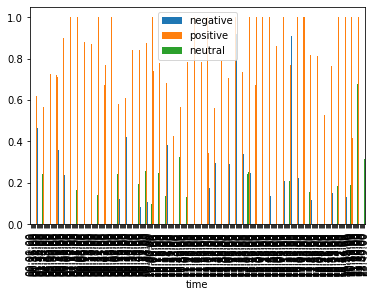

In [43]:
plot_day.plot.bar()